In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import src.ltv.models.sbg as sbg
import src.ltv.models.bdw as bdw
from scipy.optimize import minimize
from scipy.special import beta
import pandas as pd
from numpy import exp, log, inf
from scipy.special import gammaln
from scipy import optimize
from math import isclose
import random
import sys
import math
import copy

In [3]:
from IPython import get_ipython
ip = get_ipython()
ip.run_line_magic("reload_ext", "autoreload")  # these will enable module autoreloading
ip.run_line_magic("autoreload", "2")

In [4]:
sys.path.append('/Users/mandaryna/Desktop/work_git/airflow-rebills_check/src')

from src.ltv.modules.approx_params import (
    preprocess_level
)
from utils import (
    get_rebills_sbg,
    get_rebills_lomax,
    filter_df_by_dict,
    pivot_renewals,
    get_fact_renewals,
    plot_pivot,
    plot_pivot_model
)

from src.ltv.constants import (
    DIMENSIONS,
    MAX_TENURE,
    MIN_TENURE,
    LEVELS_TO_IGNORE,
    MIN_SUBS,
    TRUE_DURATION,
    WINDOW_SIZE
)

from src.framework.db import get_db_client

DURATION_INTERVALS, MAX_TENURES = zip(*MAX_TENURE.items())
TRUE_DURATIONS = [*map(TRUE_DURATION.get, DURATION_INTERVALS)]

pd.set_option('mode.chained_assignment', None)
plt.rcParams["figure.figsize"] = (10,6)

db = get_db_client('pg_an')


In [21]:
def get_funnel_long(db, start_date, end_date, app=None, cohort_size=545, duration_intervals=DURATION_INTERVALS, max_tenures=MAX_TENURES, true_durations=TRUE_DURATIONS, dimensions=DIMENSIONS):
    '''
    Default values:
    MAX_TENURES = (15, 7, 5, 3, 1)
    DURATION_INTERVALS = (7, 30, 90, 180, 365)
    TRUE_DURATIONS = [7, 31, 92, 183, 365]
    DIMENSIONS = ['duration_interval', 'is_demo', 'category', 'app_id', 'media_source', 'tier', 'product']
    '''
    duration_intervals=", ".join(map(str, duration_intervals))
    tenure_bounds=", ".join(map(str, max_tenures))
    true_durations=", ".join(map(str, true_durations))
    dimensions = ", ".join(map(str, dimensions))
    
    funnel_query1 = f"""
    with max_tenure_bounds as (
    select
        unnest(array [{duration_intervals}]) as duration_interval,
        unnest(array [{tenure_bounds}]) as max_tenure_bound
    ), 
    true_duration_intervals as (
    select
        unnest(array [{duration_intervals}]) as duration_interval,
        unnest(array [{true_durations}]) as true_duration
    ),
    main_table as (
    select
        original_transaction_id,
        app_id,
        floor(
            (
                (extract (epoch from
                    '{end_date}'::date -
                    '1 day'::interval -
                    first_transaction_time::date -
                    coalesce(make_interval(days => demo_duration_interval::int), '0 day'::interval)
                    )
                ) / 86400
            ) / true_duration::numeric
        )::int as tenure,
        iter - 1 as iteration,
        transaction_id
    from
        shared_data.payment_data
    join
        true_duration_intervals using(duration_interval)
    where
        duration_interval is not null
        and first_transaction_time::date >= '{start_date}'::date
        and first_transaction_time::date >= '{end_date}'::date - '1 day'::interval - '{cohort_size} days'::interval
        and first_transaction_time::date <=
            '{end_date}'::date -
            '1 day'::interval -
            make_interval(days => duration_interval::int) -
            coalesce(make_interval(days => demo_duration_interval::int), '0 day'::interval)
            - '14 day'::interval
        and transaction_time::date < '{end_date}'::date
        and iter > 0
        {f"and app = '{app}'" if app else ''}
    ), attributes_table as (
    select
        original_transaction_id,
        {dimensions},
        tenure,
        iteration,
        transaction_id
    from
        main_table
    join
        subscription_process.subs_current_state using(original_transaction_id, app_id)
    ), agg_table as (
    select
        {dimensions},
        tenure,
        iteration,
        count(transaction_id) as renewals
    from
        attributes_table
    where
        iteration <= tenure
    group by
        {dimensions},
        tenure,
        iteration
    )
    select
        {dimensions},
        tenure,
        iteration,
        renewals
    from
        agg_table
    join
        max_tenure_bounds using (duration_interval)
    where
        tenure <= max_tenure_bound
    """
    return db.select_df(query=funnel_query1)

In [13]:
def get_funnel_sub(app, is_demo, duration_interval, db, start_date, end_date, cohort_size=545, 
                   duration_intervals=DURATION_INTERVALS, max_tenures=MAX_TENURES, 
                   true_durations=TRUE_DURATIONS, dimensions=DIMENSIONS):
    '''
    Default values:
    MAX_TENURES = (15, 7, 5, 3, 1)
    DURATION_INTERVALS = (7, 30, 90, 180, 365)
    TRUE_DURATIONS = [7, 31, 92, 183, 365]
    DIMENSIONS = ['duration_interval', 'is_demo', 'category', 'app_id', 'media_source', 'tier', 'product']
    '''
    duration_intervals=", ".join(map(str, duration_intervals))
    tenure_bounds=", ".join(map(str, max_tenures))
    true_durations=", ".join(map(str, true_durations))
    dimensions = ", ".join(map(str, dimensions))
    
    # Adding filtering conditions directly in the SQL query
    app_id_filter = f"and app_id = '{app}'" if app else ""
    is_demo_filter = f"and is_demo = {is_demo}" if is_demo else ""
    duration_filter = f"and duration_interval = {duration_interval}" if duration_interval else ""
    
    funnel_query_sub = f"""
    with max_tenure_bounds as (
    select
        unnest(array [{duration_intervals}]) as duration_interval,
        unnest(array [{tenure_bounds}]) as max_tenure_bound
    ), 
    true_duration_intervals as (
    select
        unnest(array [{duration_intervals}]) as duration_interval,
        unnest(array [{true_durations}]) as true_duration
    ),
    main_table as (
    select
        original_transaction_id,
        app_id,
        floor(
            (
                (extract (epoch from
                    '{end_date}'::date -
                    '1 day'::interval -
                    first_transaction_time::date -
                    coalesce(make_interval(days => demo_duration_interval::int), '0 day'::interval)
                    )
                ) / 86400
            ) / true_duration::numeric
        )::int as tenure,
        iter - 1 as iteration,
        transaction_id
    from
        shared_data.payment_data
    join
        true_duration_intervals using(duration_interval)
    where
        duration_interval is not null
        and first_transaction_time::date >= '{start_date}'::date
        and first_transaction_time::date >= '{end_date}'::date - '1 day'::interval - '{cohort_size} days'::interval
        and first_transaction_time::date <=
            '{end_date}'::date -
            '1 day'::interval -
            make_interval(days => duration_interval::int) -
            coalesce(make_interval(days => demo_duration_interval::int), '0 day'::interval)
            - '14 day'::interval
        and transaction_time::date < '{end_date}'::date
        and iter > 0
        {app_id_filter}
        {is_demo_filter}
        {duration_filter}
    ), attributes_table as (
    select
        original_transaction_id,
        {dimensions},
        tenure,
        iteration,
        transaction_id
    from
        main_table
    join
        subscription_process.subs_current_state using(original_transaction_id, app_id)
    ), agg_table as (
    select
        {dimensions},
        tenure,
        iteration,
        count(transaction_id) as renewals
    from
        attributes_table
    where
        iteration <= tenure
    group by
        {dimensions},
        tenure,
        iteration
    )
    select
        {dimensions},
        tenure,
        iteration,
        renewals
    from
        agg_table
    join
        max_tenure_bounds using (duration_interval)
    where
        tenure <= max_tenure_bound
    """
    return db.select_df(query=funnel_query_sub)


In [7]:
funnel_long_small = get_funnel_long(
    db,
    start_date = '2023-01-01',
    end_date='2023-12-31',
    max_tenures=(52, 12, 5, 2, 1),
    # dimensions=['duration_interval', 'is_demo', 'category', 'app_id', 'media_source', 'country', 'tier', 'product']
)

In [22]:
funnel_long_big = get_funnel_long(
    db,
    start_date = '2023-01-01',
    end_date='2024-04-14',
    max_tenures=(70, 12, 5, 2, 1),
    # dimensions=['duration_interval', 'is_demo', 'category', 'app_id', 'media_source', 'country', 'tier', 'product']
)

In [9]:
def get_transaction_dates(db):
  
    transaction_dates_query = f"""
    select
        app_id as app,
        is_demo as is_demo,
        duration_interval as duration_interval,
        min(transaction_time) as first_transaction,
        max(transaction_time) as last_transaction
    from
        shared_data.payment_data
    group by
        app_id,
        is_demo,
        duration_interval
    """
    
    return db.select_df(query=transaction_dates_query)

df_durations = get_transaction_dates(db)

In [10]:
df_durations

,app,is_demo,duration_interval,first_transaction,last_transaction
0,com.tlm.botan,False,30.0,2024-01-05 12:23:03.728,2024-04-24 08:52:11.106
1,com.tlm.botan,False,NaN,2023-12-29 07:45:17.266,2024-04-24 19:22:57.573
2,com.tlm.botan,True,7.0,2023-12-30 10:11:13.344,2024-04-25 17:24:02.971
3,com.tlm.location.tracker,False,30.0,2024-01-07 03:00:19.658,2024-04-25 01:33:38.636
4,id1178444023,False,7.0,2021-05-13 13:41:55.000,2024-04-25 03:01:22.000
...,...,...,...,...,...
153,idcom.tlm.botan,True,7.0,2022-08-22 16:56:09.928,2024-04-25 08:06:44.911
154,idcom.tlm.location.tracker,False,7.0,2023-02-02 20:31:41.820,2024-04-23 04:24:14.193
155,idcom.tlm.location.tracker,False,30.0,2022-09-27 10:02:14.305,2024-04-25 01:33:54.353
156,idcom.tlm.location.tracker,False,90.0,2022-09-27 10:06:45.339,2024-04-12 07:45:25.179


In [11]:
df_durations['first_transaction'] = df_durations['first_transaction']
df_durations['last_transaction'] = df_durations['last_transaction']
df_durations = df_durations[(df_durations['duration_interval'] == 7) | (df_durations['duration_interval'] == 30)]
df_durations

,app,is_demo,duration_interval,first_transaction,last_transaction
0,com.tlm.botan,False,30.0,2024-01-05 12:23:03.728,2024-04-24 08:52:11.106
2,com.tlm.botan,True,7.0,2023-12-30 10:11:13.344,2024-04-25 17:24:02.971
3,com.tlm.location.tracker,False,30.0,2024-01-07 03:00:19.658,2024-04-25 01:33:38.636
4,id1178444023,False,7.0,2021-05-13 13:41:55.000,2024-04-25 03:01:22.000
5,id1178444023,False,30.0,2021-01-05 03:59:41.000,2024-04-24 13:00:59.000
...,...,...,...,...,...
147,idastrology.daily.horoscope,True,30.0,2021-05-30 17:39:19.021,2024-04-14 01:53:30.546
149,idcom.tlm.botan,False,30.0,2024-01-07 19:05:33.933,2024-04-23 18:18:51.589
153,idcom.tlm.botan,True,7.0,2022-08-22 16:56:09.928,2024-04-25 08:06:44.911
154,idcom.tlm.location.tracker,False,7.0,2023-02-02 20:31:41.820,2024-04-23 04:24:14.193


In [12]:
df_durations['interval'] = df_durations['last_transaction'] - df_durations['first_transaction']
df_durations['start_date'] = df_durations['first_transaction'] + df_durations['interval'] * 0.1
df_durations['last_end_date'] = df_durations['last_transaction'] - df_durations['interval'] * 0.1
df_durations['first_end_date'] = df_durations['last_transaction'] - df_durations['interval'] * 0.4
df_durations

,app,is_demo,duration_interval,first_transaction,last_transaction,interval,start_date,last_end_date,first_end_date
0,com.tlm.botan,False,30.0,2024-01-05 12:23:03.728,2024-04-24 08:52:11.106,109 days 20:29:07.378000,2024-01-16 12:01:58.465800,2024-04-13 09:13:16.368200,2024-03-11 10:16:32.154800
2,com.tlm.botan,True,7.0,2023-12-30 10:11:13.344,2024-04-25 17:24:02.971,117 days 07:12:49.627000,2024-01-11 03:42:30.306700,2024-04-13 23:52:46.008300,2024-03-09 19:18:55.120200
3,com.tlm.location.tracker,False,30.0,2024-01-07 03:00:19.658,2024-04-25 01:33:38.636,108 days 22:33:18.978000,2024-01-18 00:27:39.555800,2024-04-14 04:06:18.738200,2024-03-12 11:44:19.044800
4,id1178444023,False,7.0,2021-05-13 13:41:55.000,2024-04-25 03:01:22.000,1077 days 13:19:27,2021-08-29 07:49:51.700000,2024-01-08 08:53:25.300000,2023-02-19 02:29:35.200000
5,id1178444023,False,30.0,2021-01-05 03:59:41.000,2024-04-24 13:00:59.000,1205 days 09:01:18,2021-05-05 16:53:48.800000,2023-12-26 00:06:51.200000,2022-12-29 09:24:27.800000
...,...,...,...,...,...,...,...,...,...
147,idastrology.daily.horoscope,True,30.0,2021-05-30 17:39:19.021,2024-04-14 01:53:30.546,1049 days 08:14:11.525000,2021-09-12 16:04:44.173500,2023-12-31 03:28:05.393500,2023-02-19 08:11:49.936000
149,idcom.tlm.botan,False,30.0,2024-01-07 19:05:33.933,2024-04-23 18:18:51.589,106 days 23:13:17.656000,2024-01-18 11:48:53.698600,2024-04-13 01:35:31.823400,2024-03-11 23:25:32.526600
153,idcom.tlm.botan,True,7.0,2022-08-22 16:56:09.928,2024-04-25 08:06:44.911,611 days 15:10:34.983000,2022-10-22 20:51:13.426300,2024-02-24 04:11:41.412700,2023-08-24 16:26:30.917800
154,idcom.tlm.location.tracker,False,7.0,2023-02-02 20:31:41.820,2024-04-23 04:24:14.193,445 days 07:52:32.373000,2023-03-19 09:18:57.057300,2024-03-09 15:36:58.955700,2023-10-28 01:15:13.243800


In [20]:
import os
subs_saved = []

directory_short = "funnels_new_short"
files_short = os.listdir("funnels_new_short")
directory_long = "funnels_new_long"
files_long = os.listdir("funnels_new_long")

for index, row in df_durations.iterrows():
    
    nm_short = row['app'] +"_"+ str(row['is_demo'])+"_"+str(int(row['duration_interval']))+"_"+"short.csv"
    nm_long = row['app'] +"_"+str(row['is_demo'])+"_" +str(int(row['duration_interval']))+ "_"+"long.csv"
    
    if nm_short not in files_short:
    
        short_funnel = get_funnel_sub(
        app=row['app'], 
        is_demo=row['is_demo'],
        duration_interval = int(row['duration_interval']),
        db=db,
        start_date=row['start_date'].strftime('%Y-%m-%d'), 
        end_date=row['first_end_date'].strftime('%Y-%m-%d'),  
        max_tenures=(52, 12, 5, 2, 1))

        file_path = os.path.join(directory_short, nm_short)
        short_funnel.to_csv(file_path, index=False)
        print(f"{nm_short} saved")
        files_short.append(nm_short)
        
    if nm_long not in files_long:

        long_funnel = get_funnel_sub(
        app=row['app'], 
        is_demo=row['is_demo'],
        duration_interval = int(row['duration_interval']),
        db=db,
        start_date=row['start_date'].strftime('%Y-%m-%d'), 
        end_date=row['last_end_date'].strftime('%Y-%m-%d'),  
        max_tenures=(70, 15, 5, 2, 1))

        file_path = os.path.join(directory_long, nm_long)
        long_funnel.to_csv(file_path, index=False)
        print(f"{nm_long} saved")
        files_long.append(nm_long)
        
    else:
        continue
    

id1515080485_True_30_short.csv saved
id1515080485_True_30_long.csv saved
id1557446434_False_7_short.csv saved
id1557446434_False_7_long.csv saved
id1557446434_False_30_short.csv saved
id1557446434_False_30_long.csv saved
id1557446434_True_7_short.csv saved
id1557446434_True_7_long.csv saved
id1557446434_True_30_short.csv saved
id1557446434_True_30_long.csv saved
id1559708047_False_7_short.csv saved
id1559708047_False_7_long.csv saved
id1559708047_False_30_short.csv saved
id1559708047_False_30_long.csv saved
id1559708047_True_7_short.csv saved
id1559708047_True_7_long.csv saved
id1564249382_False_7_short.csv saved
id1564249382_False_7_long.csv saved
id1564249382_False_30_short.csv saved
id1564249382_False_30_long.csv saved
id1564249382_True_7_short.csv saved
id1564249382_True_7_long.csv saved
id1564249382_True_30_short.csv saved
id1564249382_True_30_long.csv saved
id1572448973_False_30_short.csv saved
id1572448973_False_30_long.csv saved
id1584101428_False_30_short.csv saved
id158410142

Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
Short funnel


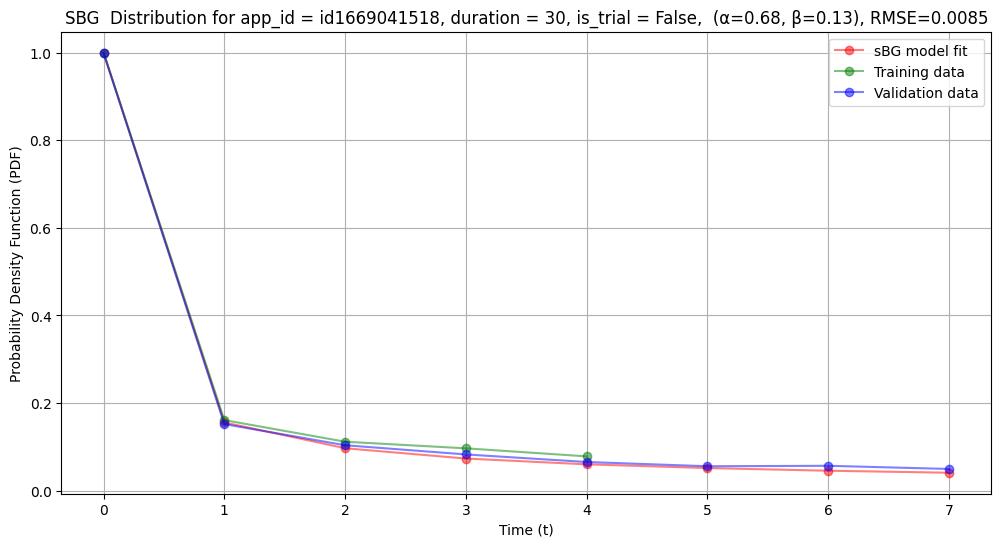

plot end


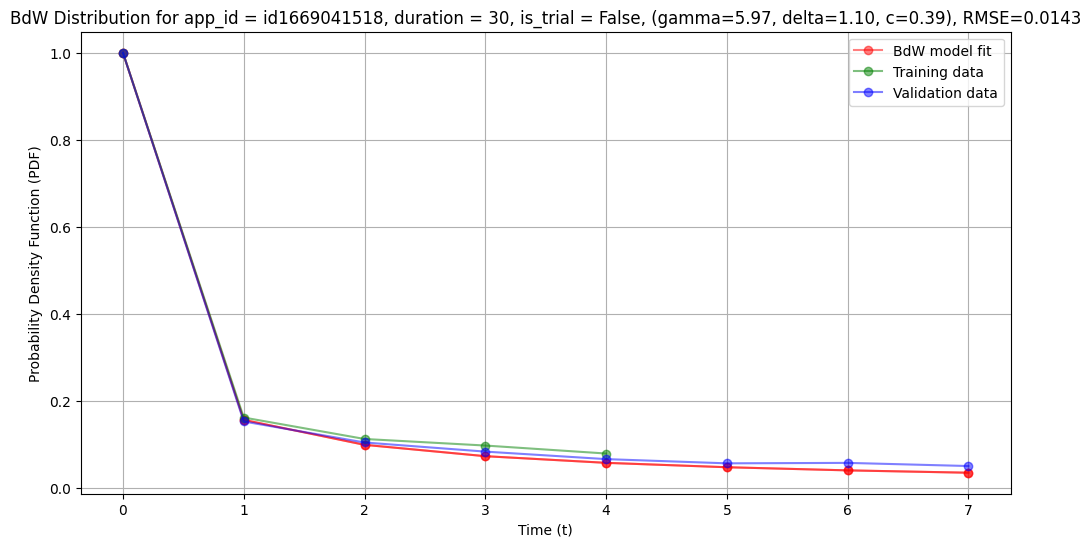

Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
max() arg is an empty sequence


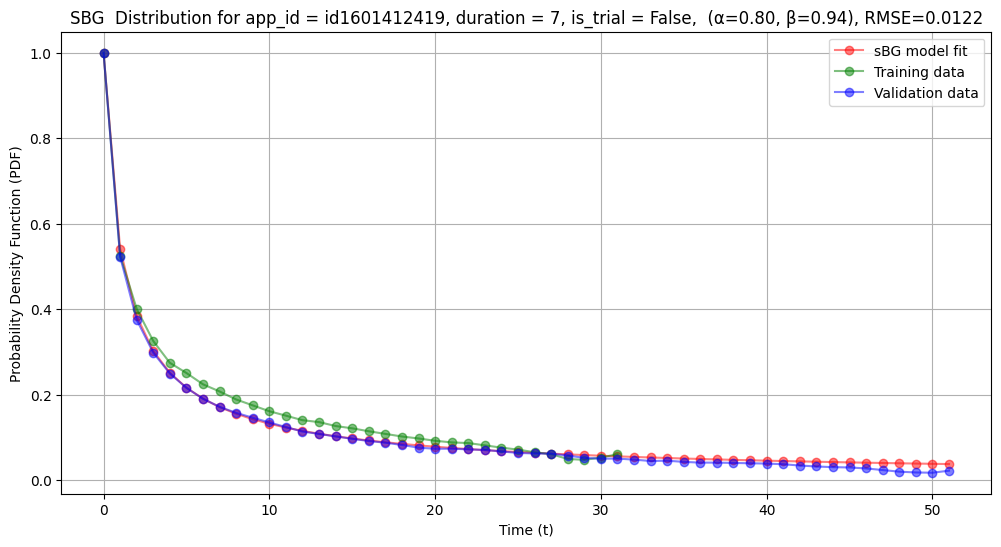

plot end


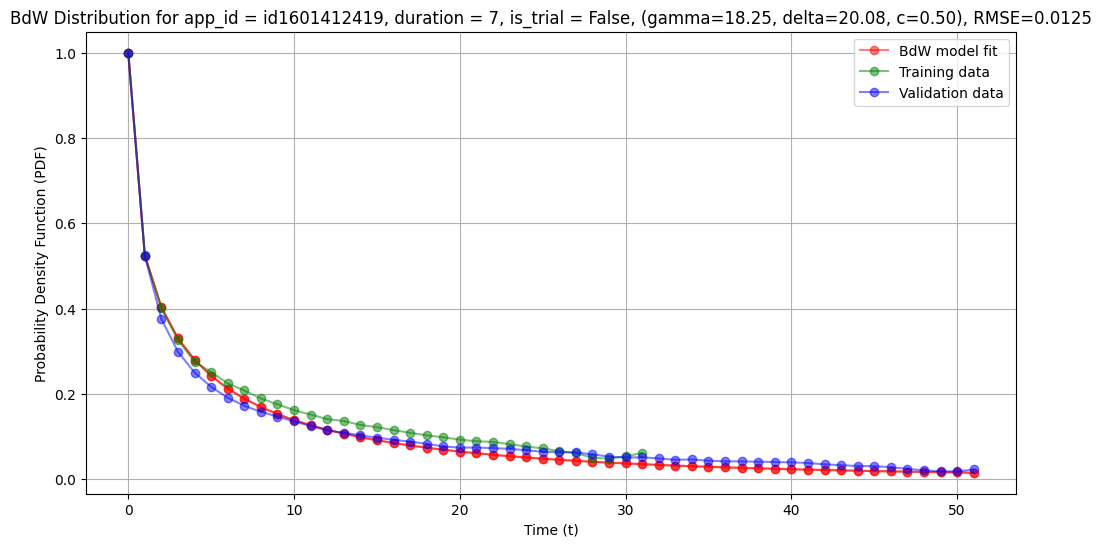

Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
Short funnel
Used moving calculation, not enough data
Used moving calculation, not enough data


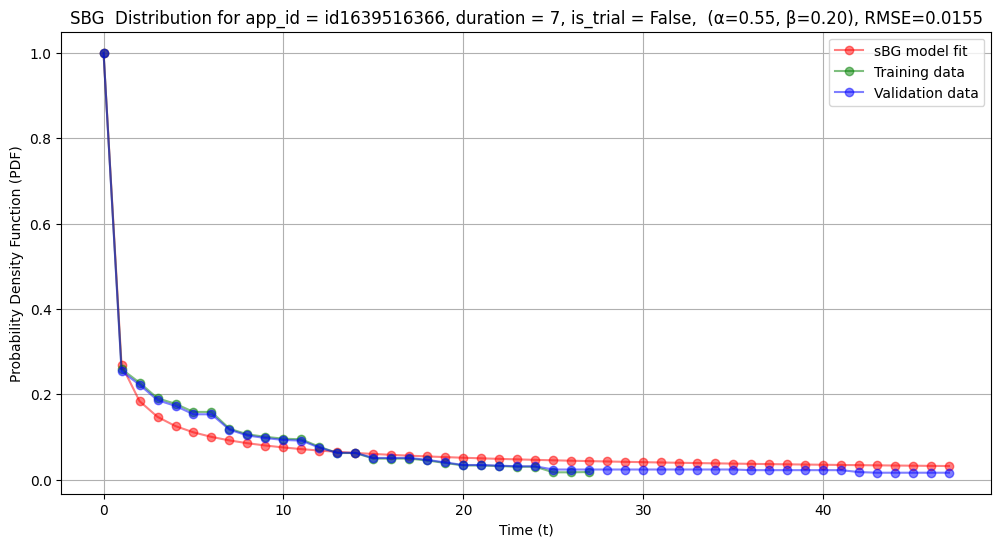

plot end


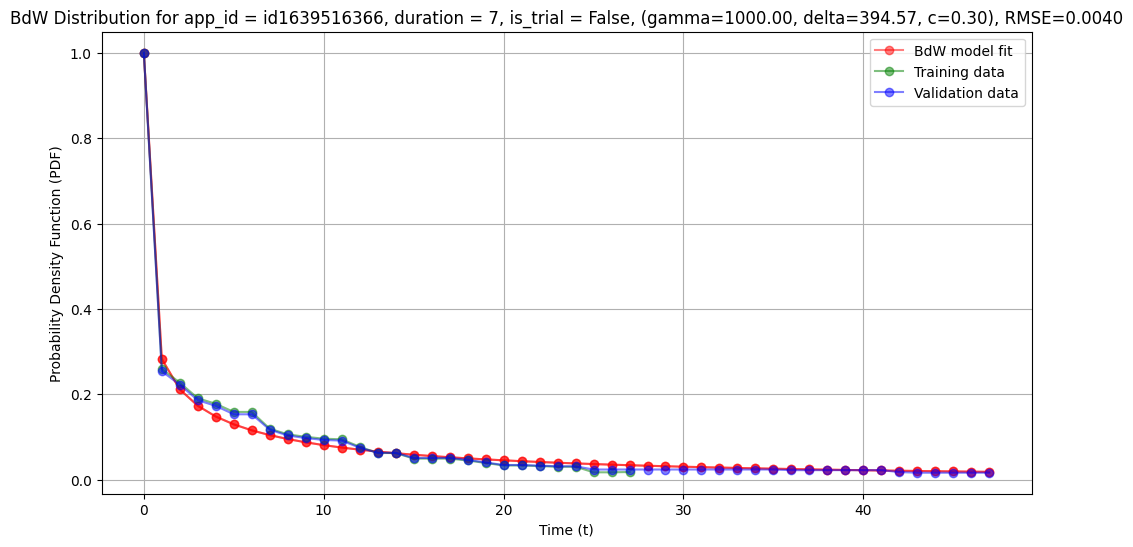

Used moving calculation, not enough data
max() arg is an empty sequence


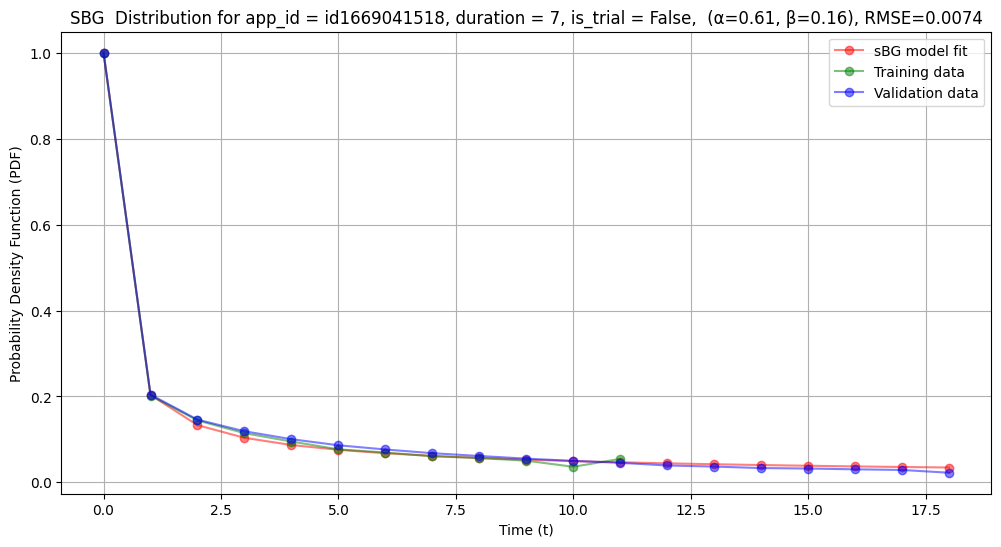

plot end


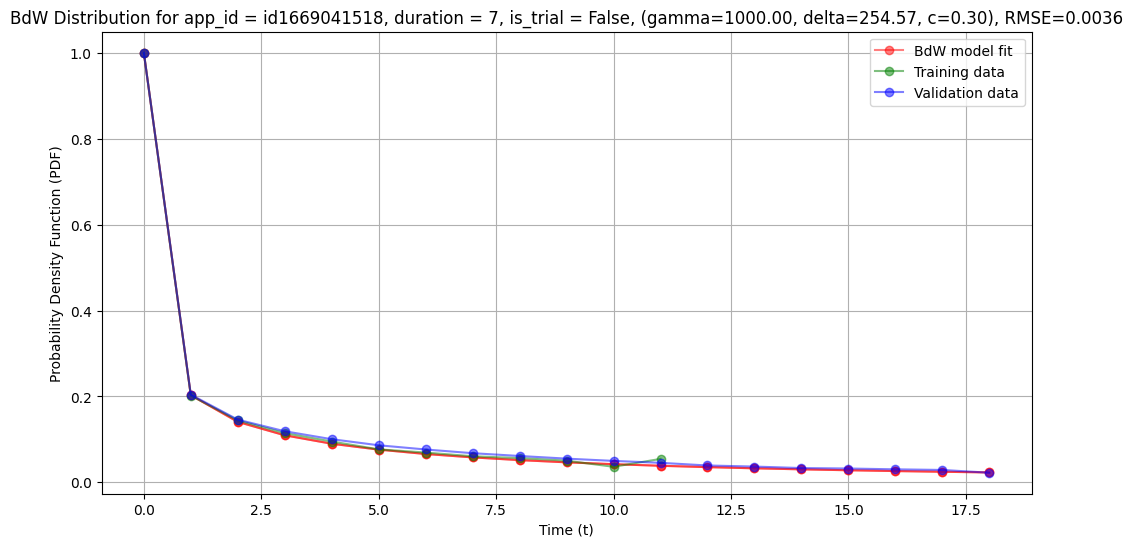

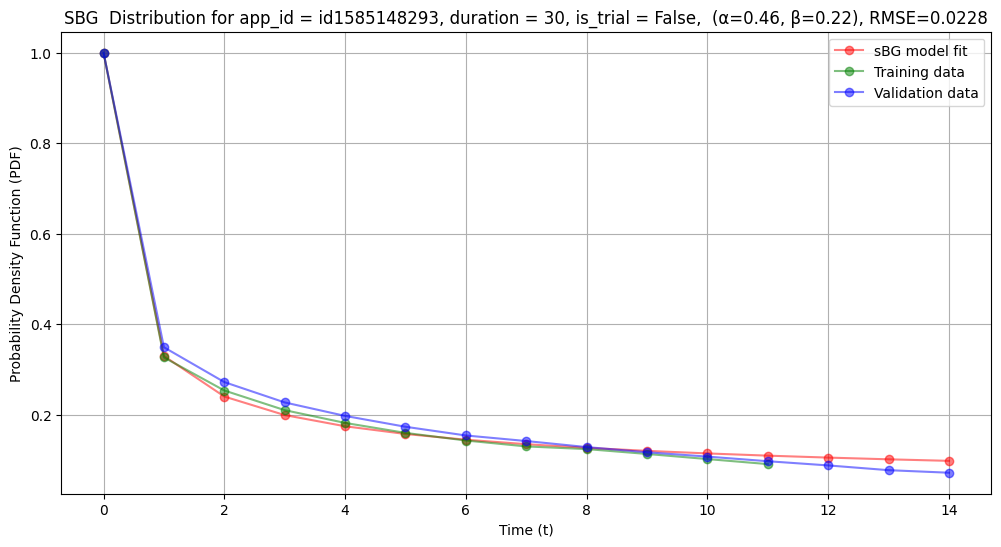

plot end


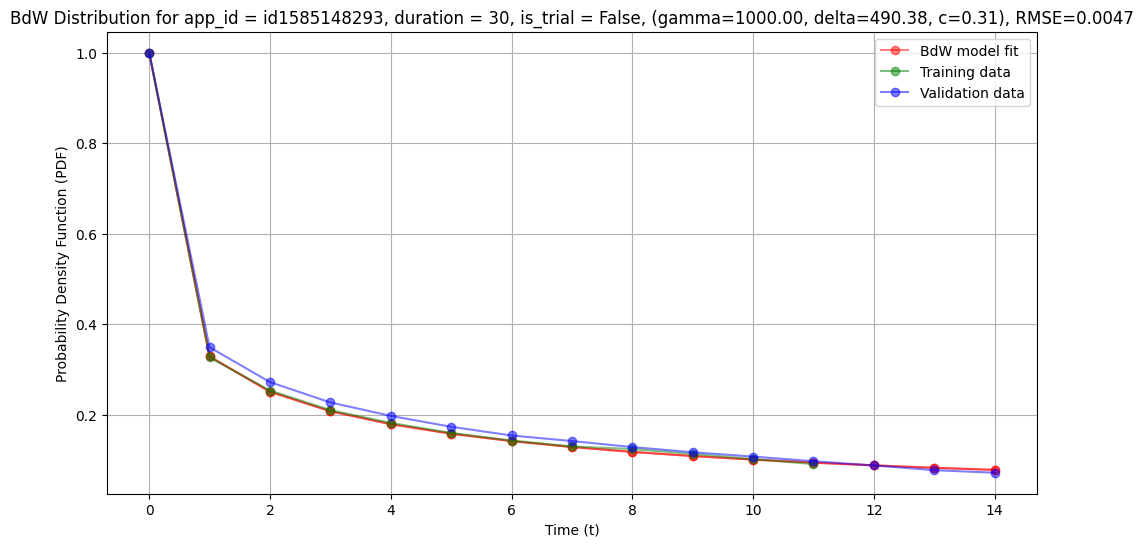

Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
Short funnel


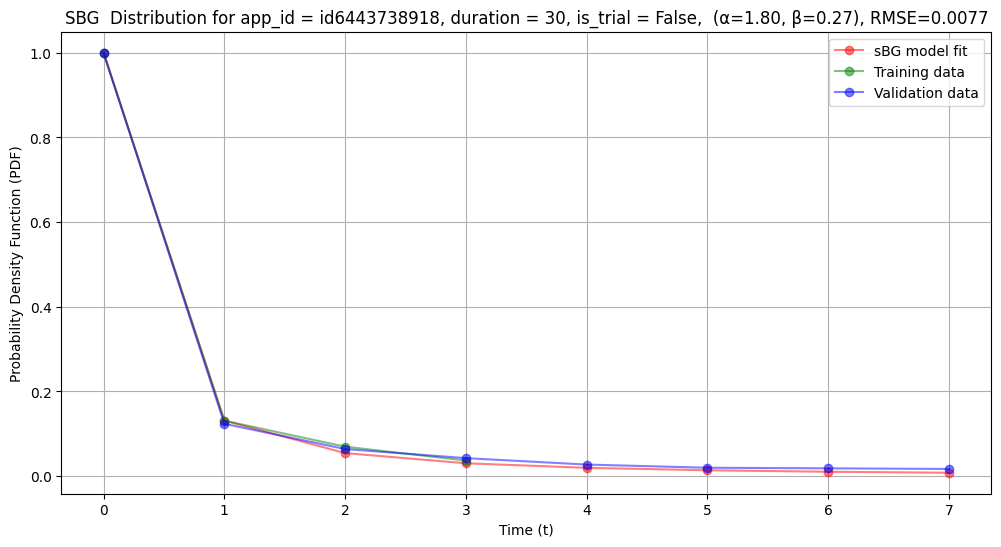

plot end


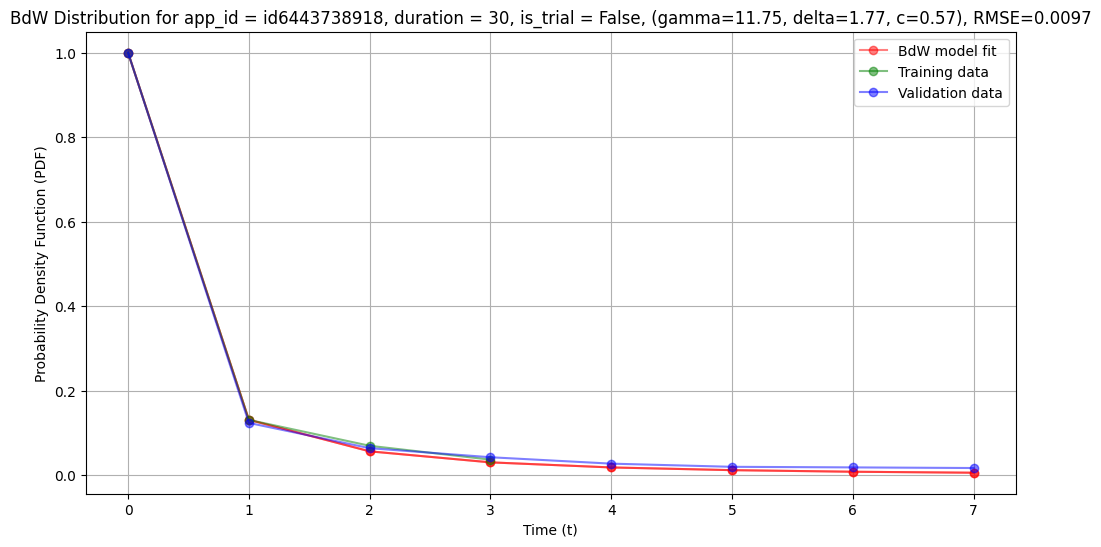

Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
Short funnel
Used moving calculation, not enough data
Short funnel


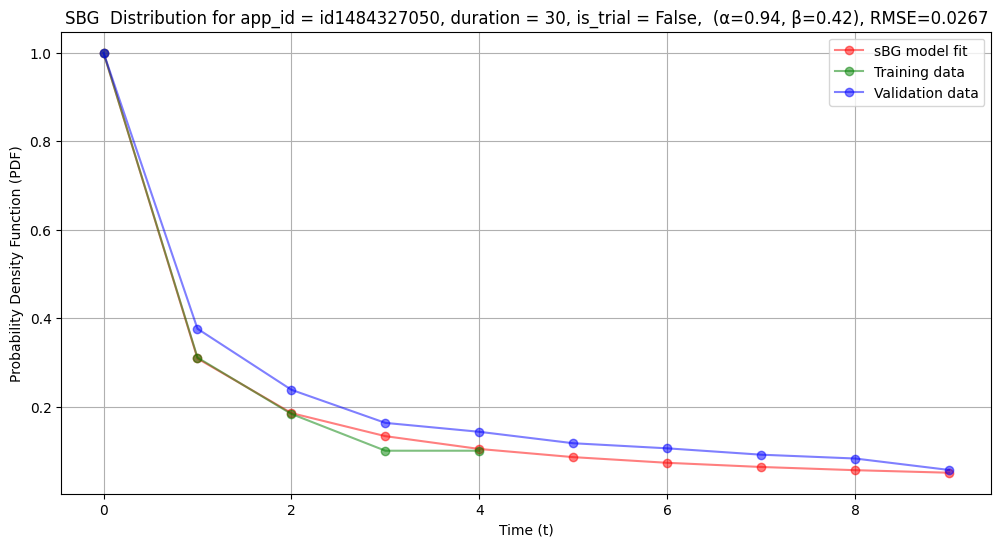

plot end


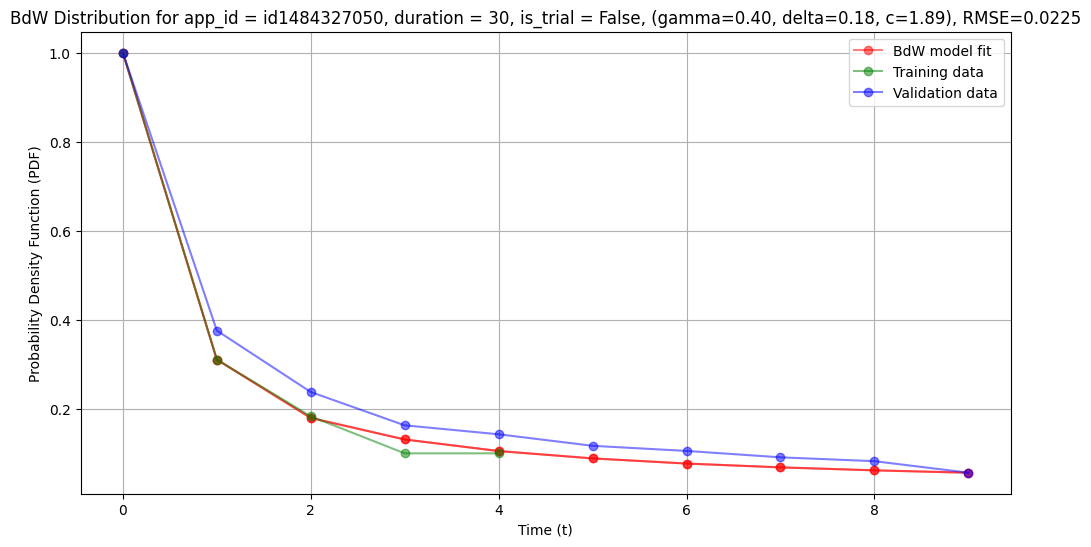

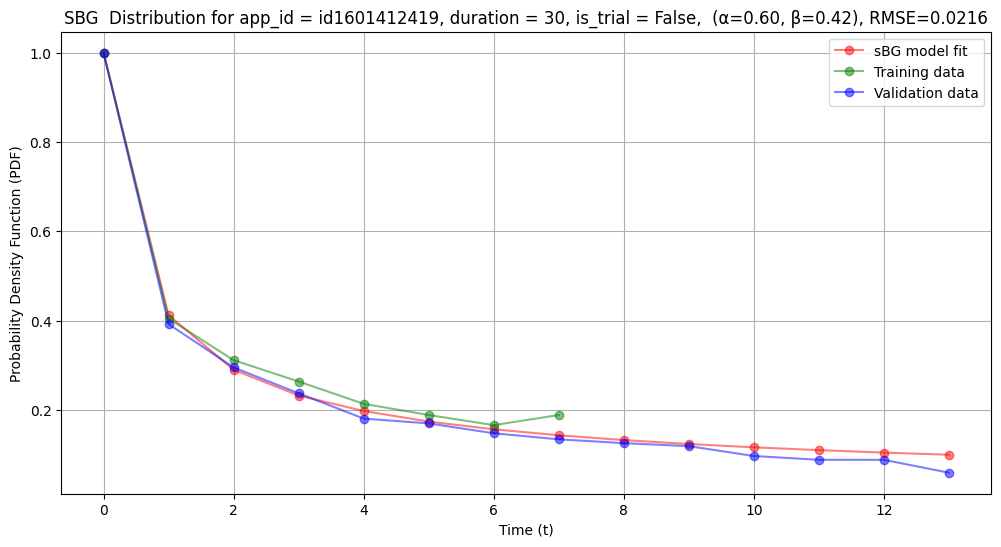

plot end


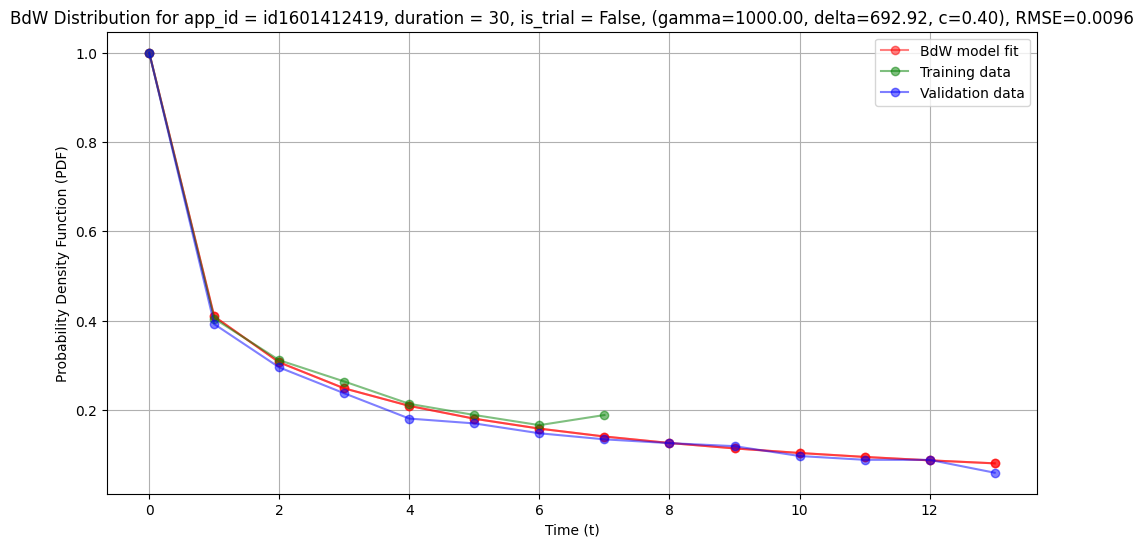

Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
Short funnel
Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
Short funnel
Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
max() arg is an empty sequence
Used moving calculation, not enough data
Used moving calculation, not enough data


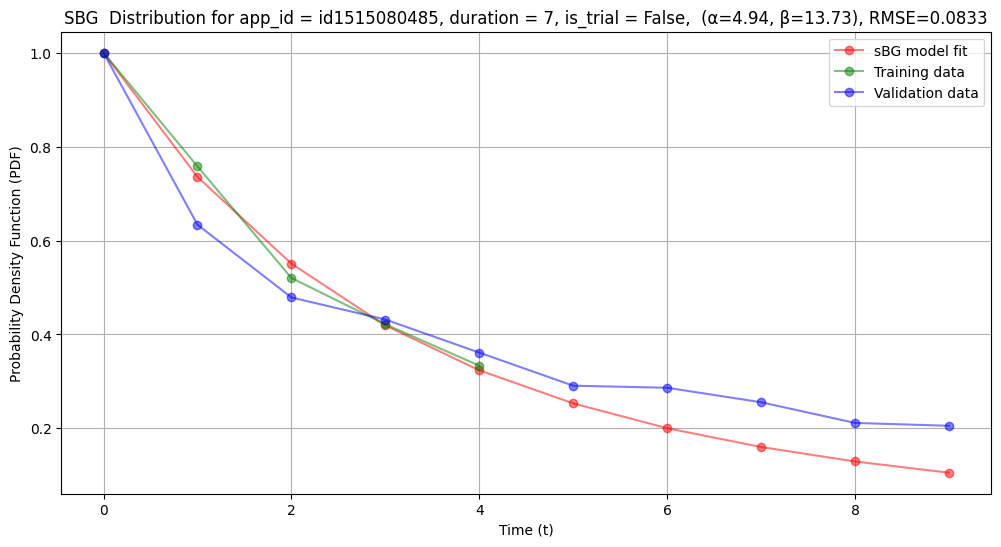

plot end


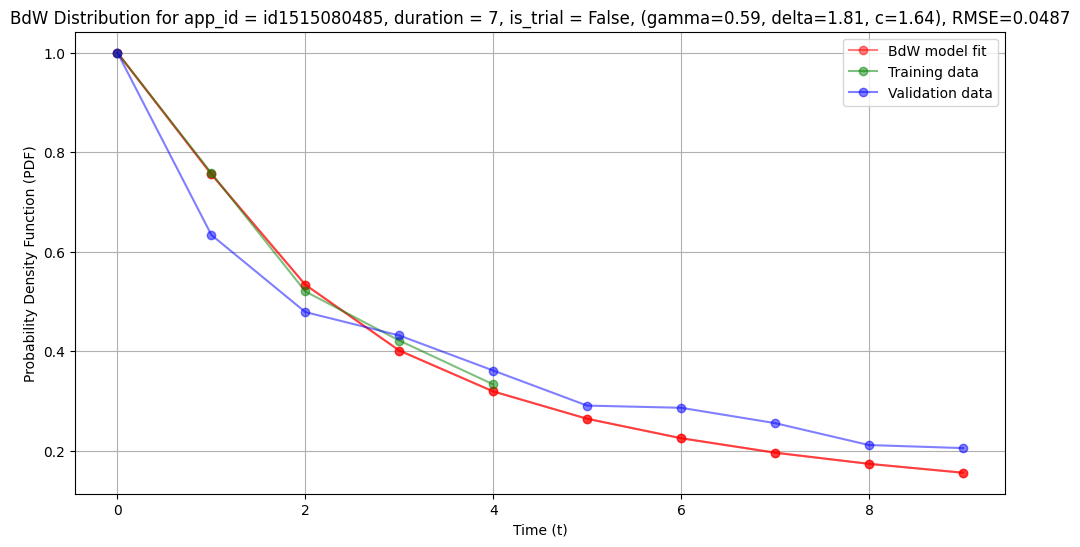

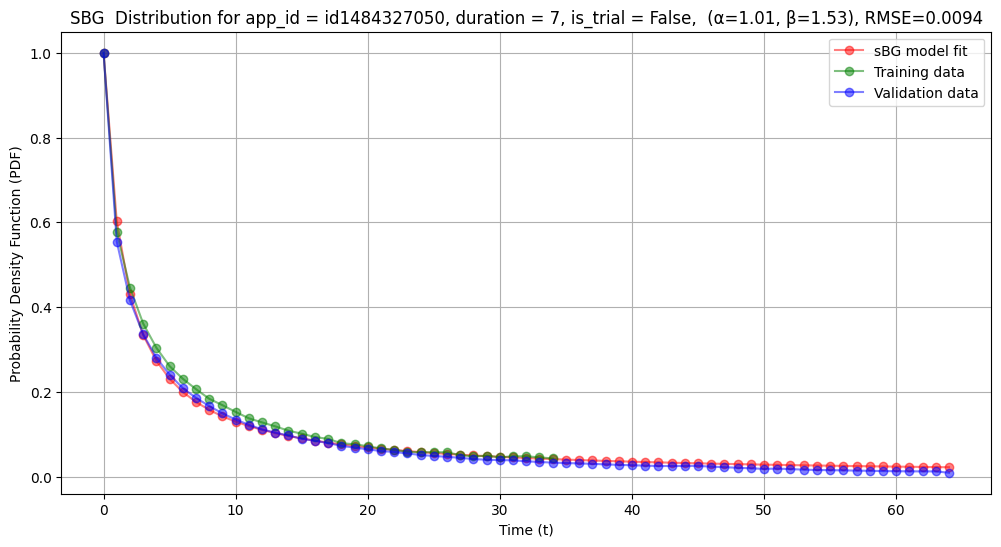

plot end


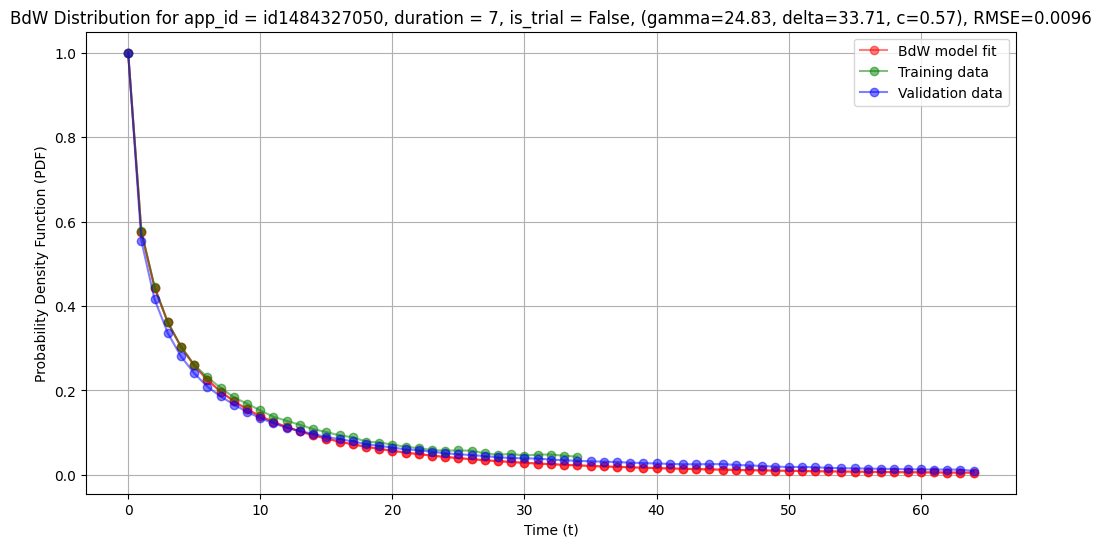

Used moving calculation, not enough data
Short funnel
Used moving calculation, not enough data
Short funnel
Used moving calculation, not enough data
max() arg is an empty sequence


In [15]:
import os
files_long = os.listdir("funnels_new_long")
files_short = os.listdir("funnels_new_short")

# filess = files[2:40]
rmses = dict()
filename_count = 0
except1_count = 0
except2_count = 0
for filename1 in files_long:
    for filename2 in files_short:
        if filename1.split('_')[:-1] == filename2.split('_')[:-1]:
            filename_count+=1
            try:
                short_funnel = pd.read_csv(os.path.join("funnels_new_short",filename2))
                long_funnel = pd.read_csv(os.path.join("funnels_new_long",filename1))
            except Exception:
                except1_count +=1
                continue
            
            app = filename1.split('_')[0]
            is_demo = filename1.split('_')[-3]
            duration = int(filename1.split('_')[-2])
            
            if is_demo == 'True':
                continue
            try:
                rmse = main_all_apps(duration, app, is_demo, long_funnel, short_funnel)                        
                # print("len shhort long")
                # print(len(short_funnel))
                # print(len(long_funnel))
                # print(rmse)
                rmses[filename1] = rmse
            except Exception as e:
                print(e)
                except2_count +=1
                continue
            else:
                pass
        # except Exception as e:
        #     print(e)
        #     continue


In [18]:
print(rmses)

{'id1669041518_False_30_long.csv': [(0.008502145554934842, 'sbg'), (0.01430776701226408, 'bdw')], 'id1601412419_False_7_long.csv': [(0.012212568064607769, 'sbg'), (0.012463491379674242, 'bdw')], 'id1639516366_False_7_long.csv': [(0.004043305989428611, 'bdw'), (0.01553091545560721, 'sbg')], 'id1669041518_False_7_long.csv': [(0.0036053927331992693, 'bdw'), (0.007422234567394497, 'sbg')], 'id1585148293_False_30_long.csv': [(0.004697577793088636, 'bdw'), (0.02281940640264869, 'sbg')], 'id6443738918_False_30_long.csv': [(0.007736738571062956, 'sbg'), (0.00965621249647705, 'bdw')], 'id1484327050_False_30_long.csv': [(0.022506780833413807, 'bdw'), (0.026677887839834012, 'sbg')], 'id1601412419_False_30_long.csv': [(0.009613431428223736, 'bdw'), (0.02160654032935113, 'sbg')], 'id1515080485_False_7_long.csv': [(0.0486844552468062, 'bdw'), (0.08325173981305335, 'sbg')], 'id1484327050_False_7_long.csv': [(0.00937798143488969, 'sbg'), (0.009638917484827123, 'bdw')]}


In [8]:
rmses = dict()


def main_all_apps(duration, app, is_demo, funnel_long_big, funnel_long_small):
    segment_info = {'duration_interval': duration, 'is_demo': is_demo, 'app_id':app}

    df_segment = funnel_long_small
    df_segment = df_segment.groupby(['tenure', 'iteration'], as_index=False)['renewals'].sum()
    if app == "id1557446434":
        df_segment = df_segment.loc[df_segment['tenure'] <= 6]  # For botan
    processed = preprocess_level(df_segment[~df_segment.isin(LEVELS_TO_IGNORE).any(axis=1)], segment_info)
    final_processed = get_fact_renewals(processed, min_users=10, omit_latest=True)
    
    df_segment2 = funnel_long_big
    df_segment2 = df_segment2.groupby(['tenure', 'iteration'], as_index=False)['renewals'].sum()
    if app == "id1557446434":
        df_segment2 = df_segment.loc[df_segment2['tenure'] <= 6]
    processed2 = preprocess_level(df_segment2[~df_segment2.isin(LEVELS_TO_IGNORE).any(axis=1)], segment_info)
    final_processed2 = get_fact_renewals(processed2, min_users=10, omit_latest=True)
    
    SBG_RMSE = plot_individual_sbg_distributions(segment_info, processed, final_processed, final_processed2, "")
    BDW_RMSE = plot_individual_bdw_distributions(segment_info, processed, final_processed, final_processed2)
    
    rmse = [(BDW_RMSE, "bdw"), (SBG_RMSE, "sbg")]
    return rmse

In [17]:
import math 

def who_won(rmses):
    bdw_rmses = []
    sbg_rmses = []    
    
    rmses = {
    key: value
    for key, value in rmses.items()
    if not any((item[0] == None) for item in value)
    }
    
    for rmse in rmses:
        lst = rmses[rmse]
        bdw_rmses.append(lst[0][0])
        sbg_rmses.append(lst[1][0])
        lst.sort(key=lambda x: x[0])

    print('avg bdw rmse:' + str(sum(bdw_rmses)/len(rmses)))
    print('avg sbg rmse:' + str(sum(sbg_rmses)/len(rmses))) 
    
    return (sum(bdw_rmses)/len(rmses), sum(sbg_rmses)/len(rmses))

results = who_won(rmses)
sbg = results[0]
bdw = results[1]

avg bdw rmse:0.013098037764965553
avg sbg rmse:0.02233751127811314


In [10]:
import numpy as np
def plot_individual_bdw_distributions(segment_info, processed, final_processed, final_processed2):
    t_values = np.arange(0, len(final_processed)) 
    
    t_values2 = np.arange(0, len(final_processed2)) 
    
    vals = bdw.fit(processed)
    gamma_bdw = vals['x'][0]
    delta_bdw = vals['x'][1]
    c_bdw = vals['x'][2]
    t_bdw = segment_info['duration_interval']
    pdf_values = bdw.get_rebills(len(final_processed2)-1, gamma_bdw, delta_bdw, c_bdw)

    RMSE = np.sqrt(np.mean((final_processed2[len(final_processed):] - pdf_values[len(final_processed):len(final_processed2)])**2))

    plt.figure(figsize=(12, 6))

    plt.plot(np.arange(0, len(pdf_values)) , pdf_values, marker='o', linestyle='-', color='red', alpha = 0.5, label='BdW model fit')
    plt.plot(t_values2, pdf_values, linestyle='-', marker='o', color='red', alpha = 0.5)
    plt.plot(t_values, final_processed,  linestyle='-', marker='o', color = 'green', alpha = 0.5, label='Training data')
    plt.plot(t_values2, final_processed2,  linestyle='-', marker='o', color='blue', alpha = 0.5, label='Validation data')
    plt.legend(loc='upper right')

    plt.xlabel('Time (t)')
    plt.ylabel('Probability Density Function (PDF)')
    plt.title(f'BdW Distribution for app_id = {segment_info["app_id"]}, duration = {segment_info["duration_interval"]}, is_trial = {segment_info["is_demo"]}, (gamma={gamma_bdw:.2f}, delta={delta_bdw:.2f}, c={c_bdw:.2f}), RMSE={RMSE:.4f}')
    plt.grid(True)
    plt.show()
    
    return RMSE

In [12]:
def plot_individual_sbg_distributions(segment_info, processed, final_processed, final_processed2, shifted):
    t_values = np.arange(0, len(final_processed)) 
    t_values2 = np.arange(0, len(final_processed2)) 
    
    params = sbg.fit(processed)['final_simplex'][0][0]
    alpha_sbg = params[0]
    beta_sbg = params[1]
    t_sbg = segment_info['duration_interval']
    predicted_rebills_sbg = sbg.get_rebills(*params,  len(final_processed2))

    RMSE = np.sqrt(np.mean((final_processed2[len(final_processed):] - predicted_rebills_sbg[len(final_processed):len(final_processed2)])**2))

    plt.figure(figsize=(12, 6))
    plt.plot(predicted_rebills_sbg[:len(t_values2)], linestyle='-', color='red',marker='o', alpha = 0.5, label='sBG model fit')
    plt.plot(t_values, final_processed,  linestyle='-', color = 'green', marker='o', alpha = 0.5, label='Training data')
    plt.plot(t_values2, final_processed2, linestyle='-', color='blue', marker='o', alpha = 0.5, label='Validation data')
    plt.legend(['sBG model fit', 'Training data', 'Validation data'], loc='upper right')
    plt.xlabel('Time (t)')
    plt.ylabel('Probability Density Function (PDF)')
    plt.title(f'SBG {shifted} Distribution for app_id = {segment_info["app_id"]}, duration = {segment_info["duration_interval"]}, is_trial = {segment_info["is_demo"]},  (α={alpha_sbg:.2f}, β={beta_sbg:.2f}), RMSE={RMSE:.4f}')
    plt.grid(True)
    plt.show()
    print("plot end")
    return RMSE